# Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import streamlit as st
import torch
import torch.nn as nn
import torch.optim as optim

# Load the dataset
file_path = "TASK-ML-INTERN.csv"
data = pd.read_csv(file_path)



# Data Preprocessing and Normalization

In [2]:
print("Dataset Shape:", data.shape)

# Handle missing values (if any)
data.dropna(inplace=True)

# Separate features and target
X = data.drop(columns=["hsi_id", "vomitoxin_ppb"])
y = data["vomitoxin_ppb"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dataset Shape: (500, 450)


# Visualizing Spectral Bands

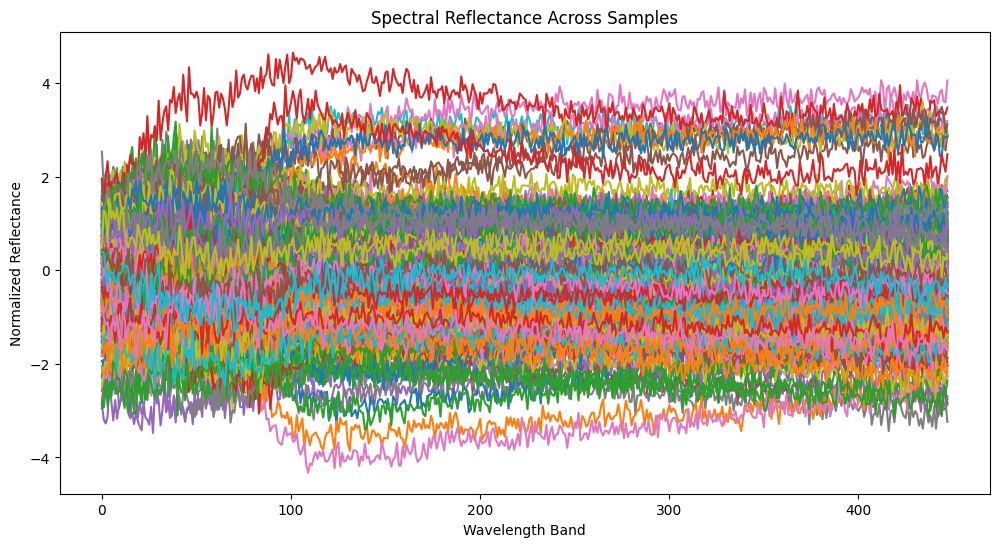

In [3]:
# Visualize spectral bands
plt.figure(figsize=(12, 6))
plt.plot(X_scaled.T)
plt.title("Spectral Reflectance Across Samples")
plt.xlabel("Wavelength Band")
plt.ylabel("Normalized Reflectance")
plt.show()



# PCA

Explained Variance Ratio: [0.87077909 0.05849069 0.02112294]


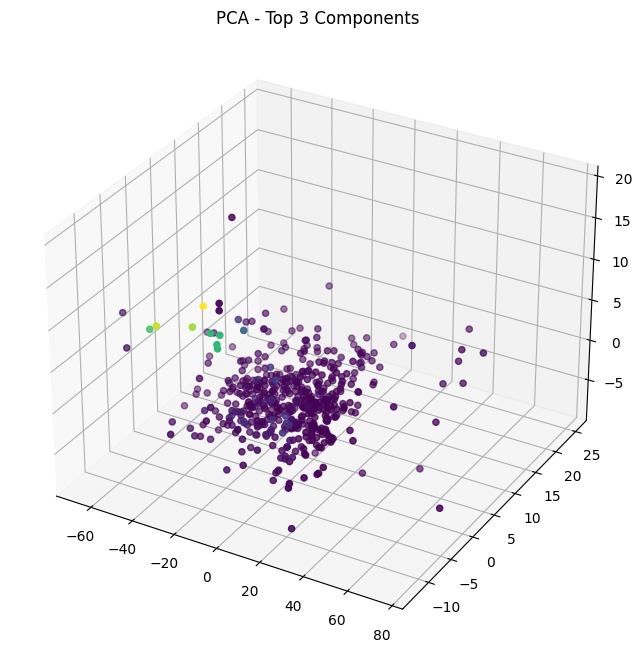

In [4]:
# Dimensionality Reduction (PCA)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 3D Plot of PCA components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
plt.title("PCA - Top 3 Components")
plt.show()

# Model Training

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Random Forest Regressor

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define parameter grid for Random Forest tuning
param_dist = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Min samples at leaf nodes
    'max_features': ['sqrt', 'log2', None]  # Feature selection
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Hyperparameter tuning
rf_search = RandomizedSearchCV(rf, param_dist, n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Get the best model
best_rf = rf_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluation Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🔹 Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")


🔹 Random Forest - MAE: 4205.7055, RMSE: 12564.4840, R²: 0.4353


In [7]:
import plotly.express as px
import pandas as pd

# Create DataFrame for plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})

# Create scatter plot
fig = px.scatter(results, x='Actual', y='Predicted', 
                 title='Actual vs Predicted Values (Random Forest)',
                 labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'},
                 opacity=0.7)

# Add a reference line (y = x)
fig.add_shape(type='line', x0=results['Actual'].min(), y0=results['Actual'].min(),
              x1=results['Actual'].max(), y1=results['Actual'].max(),
              line=dict(color='red', dash='dash'))

# Update layout for better visibility
fig.update_layout(
    width=800, height=600,
    xaxis=dict(title='Actual Values'),
    yaxis=dict(title='Predicted Values'),
    hovermode='closest'
)

# Show interactive plot
fig.show()


## Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model = Sequential()

# Input layer
model.add(Dense(128, input_shape=(X_train.shape[1],), activation="relu"))  # First hidden layer
model.add(Dropout(0.2))  # Dropout for regularization

# Second hidden layer
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

# Output layer (for regression)
model.add(Dense(1, activation="linear"))  # Linear activation for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"])

# Print model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               57472     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65793 (257.00 KB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=1000,  # Maximum number of epochs
    batch_size=32,  # Batch size
    callbacks=[early_stopping],  # Early stopping
    verbose=1
)

Epoch 1/1000
10/10 [==============================] - 0s 9ms/step - loss: 141300144.0000 - mae: 2924.1599 - val_loss: 203166624.0000 - val_mae: 4082.3794
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 141232896.0000 - mae: 2914.9231 - val_loss: 203068784.0000 - val_mae: 4072.8208
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 141119264.0000 - mae: 2902.1641 - val_loss: 202918528.0000 - val_mae: 4057.5220
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 140870816.0000 - mae: 2887.9392 - val_loss: 202731232.0000 - val_mae: 4037.2004
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 140620784.0000 - mae: 2870.0835 - val_loss: 202437536.0000 - val_mae: 4017.5254
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 140249120.0000 - mae: 2848.2793 - val_loss: 202032080.0000 - val_mae: 3997.0923
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 13

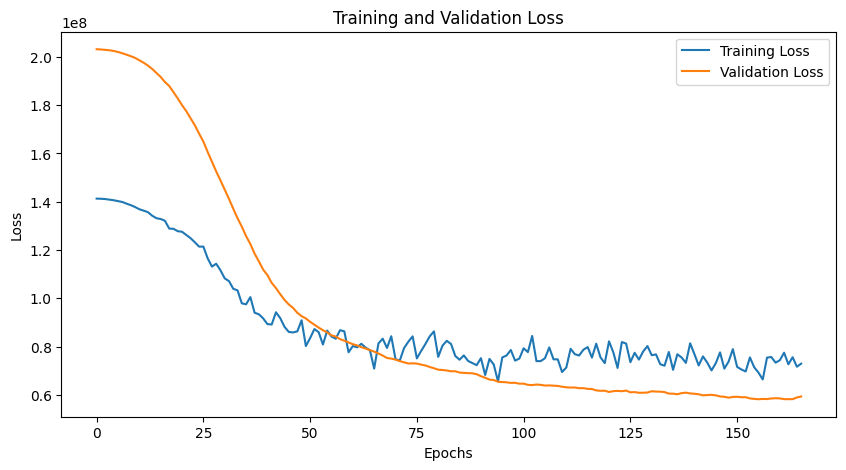

4/4 [==============================] - 0s 534us/step


In [10]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
# Predict on the test set
y_pred = model.predict(X_test).flatten()  # Flatten to convert from 2D to 1D array


In [11]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 3456.0413758713007
Root Mean Squared Error (RMSE): 10408.823845570789
R² Score: 0.6124122373719529


In [12]:
import plotly.express as px
import pandas as pd

# Create DataFrame for plotting
results_nn = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create scatter plot
fig = px.scatter(results_nn, x='Actual', y='Predicted', 
                 title='Actual vs Predicted Values (Neural Network)',
                 labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'},
                 opacity=0.7)

# Add reference line (y = x)
fig.add_shape(type='line', x0=results_nn['Actual'].min(), y0=results_nn['Actual'].min(),
              x1=results_nn['Actual'].max(), y1=results_nn['Actual'].max(),
              line=dict(color='red', dash='dash'))

# Update layout for better visibility
fig.update_layout(
    width=800, height=600,
    xaxis=dict(title='Actual Values'),
    yaxis=dict(title='Predicted Values'),
    hovermode='closest'
)

# Show interactive plot
fig.show()


# Comparitive Study

In [14]:
import plotly.graph_objects as go

# Create table data
metrics = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R² Score']
random_forest_values = [mae_rf, rmse_rf, r2_rf]
nn_values = [mae, rmse, r2]

# Create the table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Metric', 'Random Forest', 'Neural Network'],
                fill_color='lightgrey',
                align='center'),
    cells=dict(values=[metrics, random_forest_values, nn_values],
               fill_color='white',
               align='center'))
])

# Update layout
fig.update_layout(title='Model Performance Comparison')

# Show table
fig.show()


### Since Neural Network is the better model we will use it for Streamlit App development

In [15]:
model.save("best_nn_model.h5")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

